In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
import pickle

In [32]:
#!pip install huggingface_hub

In [33]:
# ---- NLTK Setup -----

def setup_nltk():
    print("CHecking NLTK data")
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading 'punkt' tokenizer...")
        nltk.download('punkt')
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        print("Downloading 'stopwords'...")
        nltk.download('stopwords')
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        print("Downloading 'wordnet' lemmatizer...")
        nltk.download('wordnet')
    print("NLTK setup complete.")


# Layer 1 Phishing detection

In [34]:
df = pd.read_csv("hf://datasets/zefang-liu/phishing-email-dataset/Phishing_Email.csv",index_col = 0)


In [35]:
#df.to_csv('Phishing_Email.csv', index = False)

In [36]:
df["Email Type"].value_counts()
# imbalanced dataset 1.5 difference but is considered mild 



Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

In [37]:
df["Email Text"].tail(20)

18631    s . hattori dies this is the english version o...
18632    Update of /cvsroot/spamassassin/spamassassin\n...
18633    weekly deal report this is the weekly report c...
18634    This article from NYTimes.com \nhas been sent ...
18635    congratulations you have won ! ! ! pls contact...
18636    On Fri, 4 Oct 2002, Mark Derricutt wrote:> Any...
18637    prior month misnomination daren - - - - for 4 ...
18638                                                empty
18639    strong buy alert : monthly newsletter topstock...
18640    out of office i have an appointment today and ...
18641    list of english taboo words does anyone have a...
18642    interview with the enron research group good m...
18643    URL: http://diveintomark.org/archives/2002/09/...
18644                                                empty
18645    \nRick Moen  a Ã©crit:> > I'm confused. I thou...
18646    date a lonely housewife always wanted to date ...
18647    request submitted : access request for anita ..

In [38]:
import pandas as pd
from collections import Counter

def analyze_line_prefixes(df, column_name="Email Text", prefix_length=5):
    """
    Analyze the first N characters of every line in email text.
    
    Parameters:
    - df: DataFrame containing email data
    - column_name: Name of the column with email text
    - prefix_length: Number of characters to extract from start of each line
    
    Returns:
    - Dictionary with prefix statistics
    """
    all_prefixes = []
    
    for idx, text in df[column_name].items():
        if pd.isna(text):
            continue
        
        lines = str(text).split('\n')
        for line in lines:
            if line.strip():  # Only non-empty lines
                prefix = line[:prefix_length]
                all_prefixes.append(prefix)
    
    # Count occurrences
    prefix_counts = Counter(all_prefixes)
    
    return prefix_counts


def print_unique_prefixes(df, column_name="Email Text", prefix_length=5, min_count=1, top_n=None):
    """
    Print unique prefixes found at the start of lines.
    
    Parameters:
    - df: DataFrame containing email data
    - column_name: Name of the column with email text
    - prefix_length: Number of characters to extract
    - min_count: Minimum occurrence count to display
    - top_n: If set, only show top N most common prefixes
    """
    prefix_counts = analyze_line_prefixes(df, column_name, prefix_length)
    
    # Filter by minimum count
    filtered_prefixes = {k: v for k, v in prefix_counts.items() if v >= min_count}
    
    # Sort by count (descending)
    sorted_prefixes = sorted(filtered_prefixes.items(), key=lambda x: x[1], reverse=True)
    
    # Limit to top N if specified
    if top_n:
        sorted_prefixes = sorted_prefixes[:top_n]
    
    print(f"Total unique prefixes (first {prefix_length} chars): {len(filtered_prefixes)}")
    print(f"Total lines analyzed: {sum(prefix_counts.values())}")
    print("\n" + "="*60)
    print(f"{'Prefix':<20} {'Count':<10} {'Percentage':<10}")
    print("="*60)
    
    total_count = sum(prefix_counts.values())
    for prefix, count in sorted_prefixes:
        percentage = (count / total_count) * 100
        # Show special characters explicitly
        display_prefix = repr(prefix)[1:-1]  # Remove outer quotes from repr
        print(f"{display_prefix:<20} {count:<10} {percentage:>6.2f}%")
    
    return sorted_prefixes


def find_common_patterns(df, column_name="Email Text", min_occurrence=10):
    """
    Find common patterns that might need to be removed (e.g., 'Re:', 'From:', etc.)
    """
    patterns = []
    
    # Common email prefixes to look for
    keywords = ['re:', 'fw:', 'fwd:', 'from:', 'to:', 'subject:', 'date:', 
                'sent:', 'cc:', 'bcc:', '>', '|', '--', '==', '**']
    
    for text in df[column_name].dropna():
        lines = str(text).split('\n')
        for line in lines:
            line_lower = line.lower().strip()
            for keyword in keywords:
                if line_lower.startswith(keyword):
                    patterns.append(keyword)
    
    pattern_counts = Counter(patterns)
    
    print("\n" + "="*60)
    print("Common email artifacts found:")
    print("="*60)
    for pattern, count in pattern_counts.most_common():
        if count >= min_occurrence:
            print(f"{pattern:<20} {count:>10} occurrences")
    
    return pattern_counts


# Example usage:
# Load your dataset
# df = pd.read_csv("phishing_email_dataset.csv")

# Analyze first 5 characters of each line
# print_unique_prefixes(df, column_name="Email Text", prefix_length=5, top_n=50)

# Find common patterns
# find_common_patterns(df, column_name="Email Text", min_occurrence=10)

In [39]:
print_unique_prefixes(df, column_name="Email Text", prefix_length=5, top_n=50)

Total unique prefixes (first 5 chars): 32952
Total lines analyzed: 168045

Prefix               Count      Percentage
                     13803        8.21%
http:                3302         1.96%
>                    1835         1.09%
re :                 1604         0.95%
-----                1214         0.72%
Â\xa0                1071         0.64%
>                    925          0.55%
_____                924          0.55%
This                 902          0.54%
https                803          0.48%
Spama                708          0.42%
Date:                630          0.37%
URL:                 625          0.37%
Irish                609          0.36%
List                 608          0.36%
empty                534          0.32%
>                    507          0.30%
--                   483          0.29%
that                 464          0.28%
fw :                 404          0.24%
=====                393          0.23%
your                 390          0.23%
wi

[('     ', 13803),
 ('http:', 3302),
 ('> ', 1835),
 ('re : ', 1604),
 ('-----', 1214),
 ('Â\xa0', 1071),
 ('>', 925),
 ('_____', 924),
 ('This ', 902),
 ('https', 803),
 ('Spama', 708),
 ('Date:', 630),
 ('URL: ', 625),
 ('Irish', 609),
 ('List ', 608),
 ('empty', 534),
 ('>    ', 507),
 ('-- ', 483),
 ('that ', 464),
 ('fw : ', 404),
 ('=====', 393),
 ('your ', 390),
 ('with ', 379),
 ('RPM-L', 376),
 ('    T', 357),
 ('\t\t\t\t\t', 341),
 ('Razor', 316),
 ('Exmh-', 308),
 ('Click', 291),
 ('Welco', 286),
 ('> the', 271),
 ('this ', 250),
 ('If yo', 249),
 ('from ', 248),
 ('start', 247),
 ('    S', 238),
 ('Â\xa0Â\xa0Â', 228),
 ('\tfont', 228),
 ('have ', 221),
 ('    t', 212),
 ('    B', 212),
 ('will ', 207),
 ('    M', 205),
 ('*****', 202),
 ('Â\xa0Lat', 202),
 ('of th', 200),
 ('Pleas', 195),
 ('    h', 194),
 ('    C', 188),
 ('inter', 187)]

In [40]:
find_common_patterns(df, column_name="Email Text", min_occurrence=10)


Common email artifacts found:
>                         18220 occurrences
--                         2219 occurrences
date:                       650 occurrences
|                           562 occurrences
**                          439 occurrences
==                          424 occurrences
from:                        62 occurrences
cc:                          22 occurrences
to:                          14 occurrences


Counter({'>': 18220,
         '--': 2219,
         'date:': 650,
         '|': 562,
         '**': 439,
         '==': 424,
         'from:': 62,
         'cc:': 22,
         'to:': 14,
         're:': 3,
         'subject:': 2})

In [41]:
analyze_line_prefixes(df)

Counter({'     ': 13803,
         'http:': 3302,
         '> ': 1835,
         're : ': 1604,
         '-----': 1214,
         'Â\xa0': 1071,
         '>': 925,
         '_____': 924,
         'This ': 902,
         'https': 803,
         'Spama': 708,
         'Date:': 630,
         'URL: ': 625,
         'Irish': 609,
         'List ': 608,
         'empty': 534,
         '>    ': 507,
         '-- ': 483,
         'that ': 464,
         'fw : ': 404,
         '=====': 393,
         'your ': 390,
         'with ': 379,
         'RPM-L': 376,
         '    T': 357,
         '\t\t\t\t\t': 341,
         'Razor': 316,
         'Exmh-': 308,
         'Click': 291,
         'Welco': 286,
         '> the': 271,
         'this ': 250,
         'If yo': 249,
         'from ': 248,
         'start': 247,
         '    S': 238,
         'Â\xa0Â\xa0Â': 228,
         '\tfont': 228,
         'have ': 221,
         '    t': 212,
         '    B': 212,
         'will ': 207,
         '    M': 205,
 

In [42]:
def create_processed_text_column(df, text_column_name="Email Text"):
    """
    Takes a DataFrame and creates a new 'processed_text' column.
    
    This function defines and applies a multi-step cleaning pipeline
    to every email in the specified text column.
    """
    
    # 1. Initialize our tools
    lemmatizer = WordNetLemmatizer()
    
    # 2. Create an *expanded* stop word list.
    # We add the email/spam artifacts you found in your analysis.
    stop_words = set(stopwords.words('english'))
    
    # Add artifacts from your log (lowercased)
    # This is a key part of tailoring the model to the data!
    email_junk = {
        're', 'fw', 'fwd', 'subject', 'date', 'from', 'to', 'cc', 
        'spama', 'spamassassin', 'razor', 'exmh', 'rpm-l',
        'nbsp', 'html', 'font', 'http', 'https'
    }
    stop_words.update(email_junk)

    def clean_text(text):
        """
        The full 7-step cleaning pipeline for a single email (string).
        """
        # Step 0: Handle non-string data (like empty cells)
        if not isinstance(text, str):
            return ""

        # Step 1: Fix Encoding & Remove Junk (from your analysis)
        # This fixes things like 'Â\xa0' which is a misread non-breaking space
        text = text.replace(u'Â\xa0', ' ')
        
        # Remove reply quotes and other line-starting junk
        # e.g., "> this is a reply" -> " this is a reply"
        text = re.sub(r'^\s*>\s?', '', text, flags=re.MULTILINE)
        
        # Remove separators
        text = re.sub(r'[-_=]{4,}', '', text) # ----, ====, ____

        # Step 2: Lowercase
        text = text.lower()

        # Step 3: Normalize (Token Replacement)
        # This must be done *before* punctuation removal.
        text = re.sub(r'http\S+|www\S+|https\S+', ' _URL_ ', text, flags=re.MULTILINE)
        text = re.sub(r'[\w\.-]+@[\w\.-]+', ' _EMAIL_ ', text, flags=re.MULTILINE)
        text = re.sub(r'\d+', ' _NUM_ ', text, flags=re.MULTILINE)

        # Step 4: Tokenize
        # Splits the string into a list of words, e.g., ["hello", "world", "!"]
        try:
            tokens = word_tokenize(text)
        except Exception:
            tokens = text.split() # Fallback for complex errors

        # Step 5: Remove Punctuation & Stop Words
        # We only keep alphabetic words AND our new tokens
        clean_tokens = []
        for word in tokens:
            if word in ['_URL_', '_EMAIL_', '_NUM_']:
                clean_tokens.append(word)
            elif word.isalpha() and word not in stop_words:
                clean_tokens.append(word)

        # Step 6: Lemmatize
        # Converts words to their root: "verifying" -> "verify"
        # This helps the model group similar words
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]

        # Step 7: Join
        # Convert the list of words back into a single string
        return ' '.join(lemmatized_tokens)

    # --- Run the Pipeline on the DataFrame ---
    print(f"Starting text processing on '{text_column_name}' column...")
    start_time = time.time()
    
    # This .apply() runs the 'clean_text' function on every single row
    df['processed_text'] = df[text_column_name].apply(clean_text)
    
    end_time = time.time()
    print(f"Processing complete in {end_time - start_time:.2f} seconds.")
    
    return df

In [43]:
setup_nltk()

# 2. Load your dataset
# We'll create a small dummy dataset for this example.
# In your project, you'll load the real one.
print("\n--- Running on Example Data ---")
data = df

df = pd.DataFrame(data)
print("Original DataFrame:")
print(df)

# 3. Run the processing function
df_clean = create_processed_text_column(data, text_column_name="Email Text")

# 4. Show the result
print("\nProcessed DataFrame:")
print(df_clean[['Email Text', 'processed_text', 'Email Type']])

CHecking NLTK data
NLTK setup complete.

--- Running on Example Data ---
Original DataFrame:
                                              Email Text      Email Type
0      re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1      the other side of * galicismos * * galicismo *...      Safe Email
2      re : equistar deal tickets are you still avail...      Safe Email
3      \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4      software at incredibly low prices ( 86 % lower...  Phishing Email
...                                                  ...             ...
18646  date a lonely housewife always wanted to date ...  Phishing Email
18647  request submitted : access request for anita ....      Safe Email
18648  re : important - prc mtg hi dorn & john , as y...      Safe Email
18649  press clippings - letter on californian utilit...      Safe Email
18650                                              empty  Phishing Email

[18650 rows x 2 columns]
Start

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\djibr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing complete in 62.19 seconds.

Processed DataFrame:
                                              Email Text  \
0      re : 6 . 1100 , disc : uniformitarianism , re ...   
1      the other side of * galicismos * * galicismo *...   
2      re : equistar deal tickets are you still avail...   
3      \nHello I am your hot lil horny toy.\n    I am...   
4      software at incredibly low prices ( 86 % lower...   
...                                                  ...   
18646  date a lonely housewife always wanted to date ...   
18647  request submitted : access request for anita ....   
18648  re : important - prc mtg hi dorn & john , as y...   
18649  press clippings - letter on californian utilit...   
18650                                              empty   

                                          processed_text      Email Type  
0      _NUM_ _NUM_ disc uniformitarianism _NUM_ sex l...      Safe Email  
1      side galicismos galicismo spanish term name im...      Safe Em

In [47]:
#df_clean.to_csv("phishing_data_cleaned.csv")

In [60]:
df_clean

,Email Text,Email Type,processed_text
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,_NUM_ _NUM_ disc uniformitarianism _NUM_ sex l...
1,the other side of * galicismos * * galicismo *...,Safe Email,side galicismos galicismo spanish term name im...
2,re : equistar deal tickets are you still avail...,Safe Email,equistar deal ticket still available assist ro...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,hello hot lil horny one dream open minded love...
4,software at incredibly low prices ( 86 % lower...,Phishing Email,software incredibly low price _NUM_ lower drap...
...,...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email,lonely housewife always wanted lonely housewif...
18647,request submitted : access request for anita ....,Safe Email,request submitted access request anita dupont ...
18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email,important prc mtg hi dorn john discovered rece...
18649,press clippings - letter on californian utilit...,Safe Email,press clipping letter californian utility plea...


# Training

In [56]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [61]:
def train_l1_model(csv_path="phishing_data_cleaned.csv"):
    # 1. Preprocessed data
    try:
        df = pd.read_csv(csv_path)
        # Drop any rows where processing might have failed
        df = df.dropna(subset=['processed_text', 'Email Type']) 
        print(f"Loaded {len(df)} clean rows from {csv_path}")
    except FileNotFoundError:
        print(f"Error: Processed file not found at {csv_path}")
        print("Please run 'Layer_1_NLP_Processor.py' first.")
        return
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return

        # 2. Feature Extraction (Vectorization)
    print("Starting TF-IDF Vectorization...")
    # Initialize the vectorizer. We'll limit it to the 5000 most
    # frequent words to keep the model fast and prevent overfitting.
    vectorizer = TfidfVectorizer(max_features=5000)
    
    # X = our features (the text)
    # y = our target (the 0 or 1 label)
    X = vectorizer.fit_transform(df['processed_text'])
    y = df['Email Type']
    
    print("Vectorization complete.")

    # 3. Split the Data
    # We'll save 20% of the data for a final, fair test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,  # Ensures repeatable results
        stratify=y       # Ensures the train/test split has the same
                         # class balance as the original dataset
    )
    print(f"Data split: {X_train.shape[0]} training, {X_test.shape[0]} testing.")

    # 4. Train the Model
    print("Training Logistic Regression model...")
    
    # We use class_weight='balanced' to handle the 1.54x imbalance.
    # The model will "pay more attention" to the minority class.
    model = LogisticRegression(
        class_weight='balanced', 
        max_iter=1000, # Ensures the model has time to converge
        random_state=42
    )
    
    model.fit(X_train, y_train)
    print("Model training complete.")

    # 5. Evaluate the Model (The Most Important Step)
    print("\n--- Model Evaluation ---")
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    
    # --- Classification Report ---
    # This is the key metric.
    # 0 = Safe, 1 = Phishing
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=['Safe (0)', 'Phishing (1)'])
    print(report)
    
    # --- Confusion Matrix ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot the confusion matrix for a nice visual
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Safe', 'Predicted Phishing'], 
                yticklabels=['Actual Safe', 'Actual Phishing'])
    plt.title('L1 Model Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('l1_confusion_matrix.png')
    print("Saved confusion matrix plot to 'l1_confusion_matrix.png'")
    
    # 6. Save the Model & Vectorizer
    # This is CRITICAL. You must save both.
    # The vectorizer "remembers" the 5000 words.
    try:
        joblib.dump(model, 'l1_nlp_model.pkl')
        joblib.dump(vectorizer, 'l1_vectorizer.pkl')
        print("\nSuccessfully saved 'l1_nlp_model.pkl' and 'l1_vectorizer.pkl'.")
        print("These files are your Layer 1 deliverables.")
    except Exception as e:
        print(f"Error saving models: {e}")



Loaded 18630 clean rows from phishing_data_cleaned.csv
Starting TF-IDF Vectorization...
Vectorization complete.
Data split: 14904 training, 3726 testing.
Training Logistic Regression model...
Model training complete.

--- Model Evaluation ---
Overall Accuracy: 96.16%

Classification Report:
              precision    recall  f1-score   support

    Safe (0)       0.94      0.97      0.95      1462
Phishing (1)       0.98      0.96      0.97      2264

    accuracy                           0.96      3726
   macro avg       0.96      0.96      0.96      3726
weighted avg       0.96      0.96      0.96      3726

Confusion Matrix:
[[1415   47]
 [  96 2168]]
Saved confusion matrix plot to 'l1_confusion_matrix.png'

Successfully saved 'l1_nlp_model.pkl' and 'l1_vectorizer.pkl'.
These files are your Layer 1 deliverables.


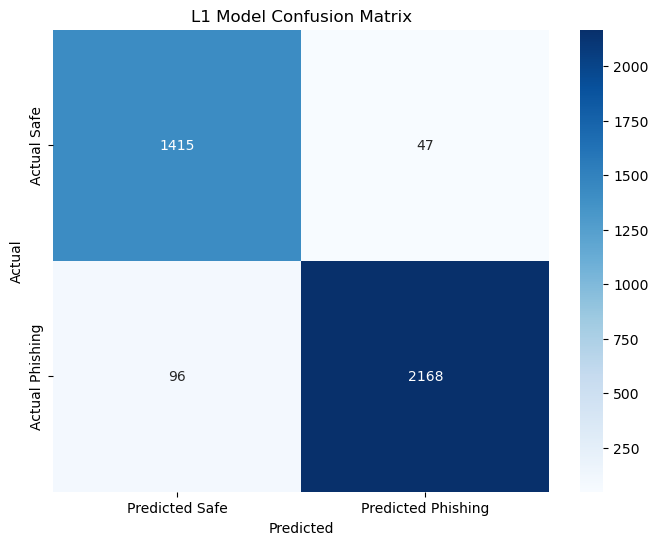

In [62]:
train_l1_model()

### NPL Preprocessing

#### Text Processing
Convert to lower case

Remove punctation & Special characters 

Remove stop words

Normalization

Lemmatization (convert words to their root)

#### Feature Extraction

Term Frequency-Inverse Document Frequency

1. Term Frequency: How often deos a word appear in this email (often = ^importantace)

2. Inverse Document Frequnecy: How rare is this word across all emails (rarer = special)


#### Handling the Imbalance
Tell the model that the dataset is slightly imbalanced (class_weight paramter)

#### Model Training

Reccomended Models

Multinomial Naive Bayes: Designed for text classifcation with word counts (fast and great baseline)

Logistic Regression: Robust, good choice with class_weight balanced 

Simple and fast to train models, less prone to overfitting compared to neural network


#### Evaluation

F1-score and it's compononents 

# Layer 2 Redirect Analysis

In [11]:
import requests
from bs4 import BeautifulSoup
import whois
from datetime import datetime
from urllib.parse import urlparse


In [7]:
#!pip install beautifulsoup4 python-whois